### Attempt to cluster sprint 3 molecules into sets

In [1]:
import numpy as np
from openforcefield.topology import Molecule
from openeye import oechem, oegraphsim, oedepict

In [2]:
all_smiles = []
all_titles = []
with open('benzotriazole.csv','r') as f:
    for line in f:
        t, s = line.split(',')
        all_smiles.append(s)
        all_titles.append(t)
        
all_smiles = all_smiles[1:]
all_titles = all_titles[1:]

n_molecules = len(all_smiles)

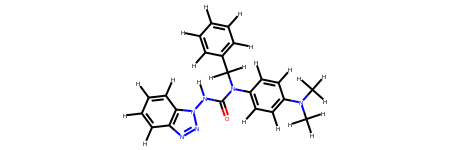

In [3]:
from openforcefield.topology import Molecule

m = Molecule.from_smiles(all_smiles[1])
m.visualize()

In [4]:
oemols = []
fingerprints = []

from perses.utils.openeye import get_scaffold

for smile, title in zip(all_smiles, all_titles):
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, smile)
    mol.SetTitle(title)
    oemols.append(mol)

    scaffold = get_scaffold(mol)
    
    fp = oegraphsim.OEFingerPrint()
    oegraphsim.OEMakeFP(fp, scaffold, oegraphsim.OEFPType_Path)
    fingerprints.append(fp)

Problematic atoms are:
Atom atomic num: 7, name: , idx: 5, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 17, aromatic: True, chiral: False



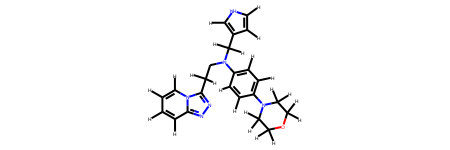

In [5]:
Molecule.from_openeye(scaffold,allow_undefined_stereo=True)

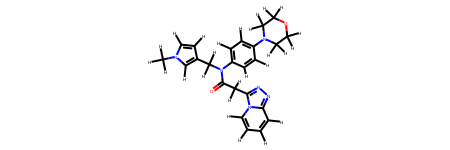

In [6]:
Molecule.from_openeye(mol,allow_undefined_stereo=True)

In [7]:
tanimoto_scores = np.ones(shape=(n_molecules,n_molecules))

for i, fA in enumerate(fingerprints):
    for j, fB in enumerate(fingerprints):
        if j > i:  
            tanimoto = oegraphsim.OETanimoto(fA, fB)
            tanimoto_scores[i,j] = tanimoto
            tanimoto_scores[j,i] = tanimoto

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x1a2b04a6a0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x1a2b04a6a0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


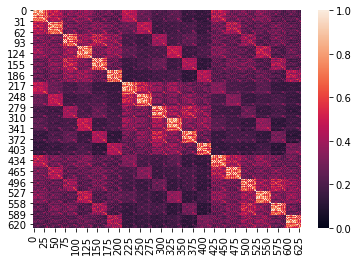

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(tanimoto_scores, vmin=0, vmax=1)
plt.show()

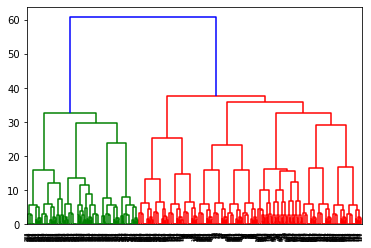

In [12]:
from scipy.cluster.hierarchy import ward, fcluster, dendrogram
from scipy.spatial.distance import pdist

linkage = ward(pdist(tanimoto_scores))

p = dendrogram(linkage)
plt.show()

In [10]:
# picking cutoff of 20 as it seems ok based on the above plot? Might be a terrible choice

cluster_occupancies = fcluster(linkage, 20, criterion='distance')
n_clusts = max(cluster_occupancies)
print(f'{n_clusts} clusters in set of {n_molecules} molecules')

11 clusters in set of 630 molecules


In [11]:
for cluster_index in range(1, max(cluster_occupancies)+1):
    cluster = [m for c,m in zip(cluster_occupancies,oemols) if c == cluster_index]
    
    cols = 6
    rows = int(np.ceil(len(cluster)/ 6))
    
    image = oedepict.OEImage(cols*200,rows*200)

    grid = oedepict.OEImageGrid(image, rows, cols)

    opts = oedepict.OE2DMolDisplayOptions(grid.GetCellWidth(), grid.GetCellHeight(),
                                           oedepict.OEScale_AutoScale)
  
    for mol, cell in zip(cluster, grid.GetCells()):
        oedepict.OEPrepareDepiction(mol)
        disp = oedepict.OE2DMolDisplay(mol, opts)
        oedepict.OERenderMolecule(cell, disp)

    oedepict.OEWriteImage(f'CLUSTER{cluster_index}.pdf', image)